In [2]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.initializers import VarianceScaling
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

import sys
sys.path.append('../')
from utils.utils import WarmUpCosineDecayScheduler, CLRScheduler, smooth_labels

### Model parameter


In [3]:

# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3
version = 1



### Dataset loading

In [42]:
def get_dataset(valid_split=True, smooth=0):
    # Load the CIFAR10 data.
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    # Input image dimensions.
    input_shape = x_train.shape[1:]

    # Normalize data.
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    x_train_mean = np.mean(x_train, axis=0)
    #x_train -= x_train_mean
    #x_test -= x_train_mean

    # Convert class vectors to binary class matrices.
    y_train = keras.utils.to_categorical(y_train, 10)
    y_test = keras.utils.to_categorical(y_test, 10)

    if valid_split:
        L = x_train.shape[0]
        p = np.arange(L)
        np.random.shuffle(p)
        valid_fraction = int(L * 0.2)
        x_val, y_val     = x_train[0:valid_fraction,...], y_train[0:valid_fraction,...]
        x_train, y_train = x_train[valid_fraction::,...], y_train[valid_fraction::,...]
    else:
        x_val, y_val = x_test, y_test
        print("Validation set is the test set")


    print('x_train shape:', x_train.shape)
    print('y_train shape:', y_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    print(x_val.shape[0], 'validation samples')

    # Smooth labels
    y_train = smooth_labels(y_train, smooth)
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

### Model generation

In [4]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer=VarianceScaling(),
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

def get_model(input_shape):
    # Computed depth from supplied model parameter n 
    if version == 2:
        depth = n * 9 + 2
        model = resnet_v2(input_shape=input_shape, depth=depth)
    else:
        depth = n * 6 + 2
        model = resnet_v1(input_shape=input_shape, depth=depth)
    return model, depth



### Learning Rate Schedule

In [24]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = base_lr
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

def get_callbacks(lr_sc, base_lr, train_examples, filepath):
    # Prepare callbacks for model saving and for learning rate adjustment.
    checkpoint = ModelCheckpoint(filepath=filepath,
                                 monitor='val_acc',
                                 verbose=1,
                                 save_best_only=True)
    callbacks = [checkpoint]

    if lr_sc == 'lr_schedule':
        schedule = LearningRateScheduler(lr_schedule)
        lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                                       cooldown=0,
                                       patience=5,
                                       min_lr=0.5e-6)
        callbacks += [lr_reducer, schedule]

    elif lr_sc == 'cosine':
        total_steps = int(epochs * train_examples / batch_size)
        warm_up_steps = 0
        schedule = WarmUpCosineDecayScheduler(learning_rate_base=base_lr,
                                                  total_steps=total_steps,
                                                  warmup_learning_rate=0.0,
                                                  warmup_steps=warm_up_steps,
                                                  hold_base_rate_steps=0)

    elif lr_sc == 'warmup_cosine':
        total_steps = int(epochs * train_examples / batch_size)
        warm_up_steps = int(total_steps / 10)
        schedule = WarmUpCosineDecayScheduler(learning_rate_base=base_lr,
                                                  total_steps=total_steps,
                                                  warmup_learning_rate=0.0,
                                                  warmup_steps=warm_up_steps,
                                                  hold_base_rate_steps=0)

    elif lr_sc == 'clrs':
        total_steps = int(epochs * train_examples / batch_size)
        schedule = CLRScheduler(max_lr=base_lr,
                                    min_lr=0.00002,
                                    total_steps=total_steps)
    else:
        print(lr_sc)

    callbacks.append(schedule)
    return callbacks

    

### Training model

In [25]:
def train_model(model, callbacks, data, data_augmentation, epochs, batch_size):
    (x_train, y_train), (x_val, y_val), (x_test, y_test) = data
    # Run training, with or without data augmentation.
    if not data_augmentation:
        print('Not using data augmentation.')
        model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_val, y_val),
                  shuffle=True,
                  callbacks=callbacks)
    else:
        print('Using real-time data augmentation.')
        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            # set input mean to 0 over the dataset
            featurewise_center=False,
            # set each sample mean to 0
            samplewise_center=False,
            # divide inputs by std of dataset
            featurewise_std_normalization=False,
            # divide each input by its std
            samplewise_std_normalization=False,
            # apply ZCA whitening
            zca_whitening=False,
            # epsilon for ZCA whitening
            zca_epsilon=1e-06,
            # randomly rotate images in the range (deg 0 to 180)
            rotation_range=0,
            # randomly shift images horizontally
            width_shift_range=0.1,
            # randomly shift images vertically
            height_shift_range=0.1,
            # set range for random shear
            shear_range=0.,
            # set range for random zoom
            zoom_range=0.,
            # set range for random channel shifts
            channel_shift_range=0.,
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            # value used for fill_mode = "constant"
            cval=0.,
            # randomly flip images
            horizontal_flip=True,
            # randomly flip images
            vertical_flip=False,
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)

        # Compute quantities required for featurewise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)

        # Fit the model on the batches generated by datagen.flow().
        model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                            validation_data=(x_test, y_test),
                            epochs=epochs, verbose=1, workers=4,
                            callbacks=callbacks,
                            steps_per_epoch=int(x_train.shape[0] / batch_size))

    # Score trained model.
    scores = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    return model, callbacks, scores[1]

In [26]:
def evaluate_training(valid_split, data_augmentation, smooth, lr_sc, batch_size, epochs, base_lr, optimizer='Adam'):
    keras.backend.clear_session()
    data = get_dataset(valid_split=valid_split, smooth=smooth)
    model, depth = get_model(data[0][0].shape[1:])
    if optimizer == 'Adam':
        optimizer = Adam(lr=base_lr)
    elif optimizer == 'RMSProp':
        optimizer = RMSprop(learning_rate=base_lr)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    model.summary()
    # Model name, depth and version
    model_type = 'ResNet%dv%d' % (depth, version)
    print(model_type)

    # Prepare model model saving directory.
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath = os.path.join(save_dir, model_name)

    callbacks = get_callbacks(lr_sc, base_lr, data[0][0].shape[0], filepath)
    model, callbacks, score = train_model(model, callbacks, data, data_augmentation, epochs, batch_size)
    return model, callbacks, score

In [27]:
valid_split = True
data_augmentation = True
lr_sc = ['lr_schedule', 'cosine', 'warmup_cosine', 'clrs', 'nasbench'][2]

# Training parameters
batch_size = 256  # orig paper trained all networks with batch_size=128
epochs = 108
base_lr = 0.01
smooth = 0.1
optimizer = 'Adam'

In [34]:
iterations = 5
# results = {}
for smooth in [0, 0.1]:
    for base_lr in [0.1, 0.01]:
        for sc in ['nasbench']:
            results[(sc, smooth, base_lr)] = []
            for i in range(iterations):
                if sc == 'nasbench':
                    optimizer = 'RMSProp'
                    sc_ = 'cosine'
                else:
                    optimizer = 'Adam'
                    sc_ = sc
                model, callbacks, score = evaluate_training(valid_split, data_augmentation, smooth, sc_, batch_size, epochs, base_lr, optimizer)
                results[(sc, smooth, base_lr)].append(score) 

x_train shape: (40000, 32, 32, 3)
y_train shape: (40000, 10)
40000 train samples
10000 test samples
10000 validation samples
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           b

Epoch 1/108
156/156 [==============================] - 13s 86ms/step - loss: 3.6091 - accuracy: 0.1398 - val_loss: 3.0406 - val_accuracy: 0.0999
Epoch 2/108
  1/156 [..............................] - ETA: 11s - loss: 2.2522 - accuracy: 0.1758

/home/cheverazo/anaconda3/envs/genetic/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


156/156 [==============================] - 10s 61ms/step - loss: 2.2450 - accuracy: 0.1851 - val_loss: 2.6229 - val_accuracy: 0.1745
Epoch 3/108
156/156 [==============================] - 10s 61ms/step - loss: 2.1184 - accuracy: 0.2109 - val_loss: 2.2318 - val_accuracy: 0.1495
Epoch 4/108
156/156 [==============================] - 10s 63ms/step - loss: 2.0672 - accuracy: 0.2356 - val_loss: 2.7168 - val_accuracy: 0.1822
Epoch 5/108
156/156 [==============================] - 10s 61ms/step - loss: 2.0176 - accuracy: 0.2535 - val_loss: 5.9020 - val_accuracy: 0.1000
Epoch 6/108
156/156 [==============================] - 10s 62ms/step - loss: 1.9710 - accuracy: 0.2776 - val_loss: 19.7062 - val_accuracy: 0.1241
Epoch 7/108
156/156 [==============================] - 10s 61ms/step - loss: 1.9423 - accuracy: 0.2974 - val_loss: 3.8211 - val_accuracy: 0.2275
Epoch 8/108
156/156 [==============================] - 9s 61ms/step - loss: 1.9099 - accuracy: 0.3125 - val_loss: 2.4496 - val_accuracy: 0.22

Epoch 1/108
156/156 [==============================] - 13s 82ms/step - loss: 3.7988 - accuracy: 0.1326 - val_loss: 3.4310 - val_accuracy: 0.1464
Epoch 2/108
  1/156 [..............................] - ETA: 7s - loss: 2.1600 - accuracy: 0.2461

/home/cheverazo/anaconda3/envs/genetic/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


156/156 [==============================] - 10s 61ms/step - loss: 2.2557 - accuracy: 0.2047 - val_loss: 2.4319 - val_accuracy: 0.1807
Epoch 3/108
156/156 [==============================] - 9s 60ms/step - loss: 2.1628 - accuracy: 0.2291 - val_loss: 3.3602 - val_accuracy: 0.0982
Epoch 4/108
156/156 [==============================] - 9s 59ms/step - loss: 2.0834 - accuracy: 0.2652 - val_loss: 11.0069 - val_accuracy: 0.1020
Epoch 5/108
156/156 [==============================] - 9s 60ms/step - loss: 2.0115 - accuracy: 0.2911 - val_loss: 2.3078 - val_accuracy: 0.2061
Epoch 6/108
156/156 [==============================] - 9s 60ms/step - loss: 1.9514 - accuracy: 0.3093 - val_loss: 25.9166 - val_accuracy: 0.1181
Epoch 7/108
156/156 [==============================] - 9s 60ms/step - loss: 1.9338 - accuracy: 0.3145 - val_loss: 2.5549 - val_accuracy: 0.2324
Epoch 8/108
156/156 [==============================] - 9s 59ms/step - loss: 1.8976 - accuracy: 0.3316 - val_loss: 1.9684 - val_accuracy: 0.3230
E

Epoch 1/108
156/156 [==============================] - 13s 84ms/step - loss: 3.4321 - accuracy: 0.1104 - val_loss: 2.9641 - val_accuracy: 0.0860
Epoch 2/108
  1/156 [..............................] - ETA: 11s - loss: 2.2610 - accuracy: 0.2109

/home/cheverazo/anaconda3/envs/genetic/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


156/156 [==============================] - 10s 63ms/step - loss: 2.3185 - accuracy: 0.1749 - val_loss: 2.3967 - val_accuracy: 0.1483
Epoch 3/108
156/156 [==============================] - 10s 61ms/step - loss: 2.1648 - accuracy: 0.1933 - val_loss: 2.7328 - val_accuracy: 0.1864
Epoch 4/108
156/156 [==============================] - 9s 60ms/step - loss: 2.0645 - accuracy: 0.2258 - val_loss: 3.3157 - val_accuracy: 0.1107
Epoch 5/108
156/156 [==============================] - 10s 62ms/step - loss: 1.9989 - accuracy: 0.2635 - val_loss: 3.2816 - val_accuracy: 0.1868
Epoch 6/108
156/156 [==============================] - 9s 60ms/step - loss: 1.9634 - accuracy: 0.2833 - val_loss: 2.4561 - val_accuracy: 0.1737
Epoch 7/108
156/156 [==============================] - 9s 60ms/step - loss: 1.9463 - accuracy: 0.2906 - val_loss: 2.4268 - val_accuracy: 0.2382
Epoch 8/108
156/156 [==============================] - 9s 60ms/step - loss: 1.9271 - accuracy: 0.2979 - val_loss: 2.8397 - val_accuracy: 0.2079
E

Epoch 1/108
156/156 [==============================] - 13s 82ms/step - loss: 3.8322 - accuracy: 0.1267 - val_loss: 2.5978 - val_accuracy: 0.1311
Epoch 2/108
  1/156 [..............................] - ETA: 10s - loss: 2.9661 - accuracy: 0.1484

/home/cheverazo/anaconda3/envs/genetic/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


156/156 [==============================] - 9s 61ms/step - loss: 2.3843 - accuracy: 0.1754 - val_loss: 2.7346 - val_accuracy: 0.1000
Epoch 3/108
156/156 [==============================] - 9s 61ms/step - loss: 2.1257 - accuracy: 0.2126 - val_loss: 2.5633 - val_accuracy: 0.1342
Epoch 4/108
156/156 [==============================] - 10s 62ms/step - loss: 2.0922 - accuracy: 0.2372 - val_loss: 3.2498 - val_accuracy: 0.1341
Epoch 5/108
156/156 [==============================] - 9s 60ms/step - loss: 2.0247 - accuracy: 0.2658 - val_loss: 3.7948 - val_accuracy: 0.1398
Epoch 6/108
156/156 [==============================] - 9s 59ms/step - loss: 1.9571 - accuracy: 0.2925 - val_loss: 2.3603 - val_accuracy: 0.2464
Epoch 7/108
156/156 [==============================] - 10s 62ms/step - loss: 1.9237 - accuracy: 0.3171 - val_loss: 7.8580 - val_accuracy: 0.1000
Epoch 8/108
156/156 [==============================] - 9s 60ms/step - loss: 1.9118 - accuracy: 0.3238 - val_loss: 2.3615 - val_accuracy: 0.2291
Ep

Epoch 1/108
156/156 [==============================] - 13s 85ms/step - loss: 3.4066 - accuracy: 0.1051 - val_loss: 2.8756 - val_accuracy: 0.1751
Epoch 2/108
  1/156 [..............................] - ETA: 11s - loss: 2.5732 - accuracy: 0.1094

/home/cheverazo/anaconda3/envs/genetic/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


156/156 [==============================] - 9s 60ms/step - loss: 2.2861 - accuracy: 0.1745 - val_loss: 4.3592 - val_accuracy: 0.1104
Epoch 3/108
156/156 [==============================] - 9s 60ms/step - loss: 2.0954 - accuracy: 0.2212 - val_loss: 2.4079 - val_accuracy: 0.1439
Epoch 4/108
156/156 [==============================] - 9s 61ms/step - loss: 2.0277 - accuracy: 0.2520 - val_loss: 4.1344 - val_accuracy: 0.1531
Epoch 5/108
156/156 [==============================] - 9s 60ms/step - loss: 1.9947 - accuracy: 0.2699 - val_loss: 2.3662 - val_accuracy: 0.1911
Epoch 6/108
156/156 [==============================] - 9s 60ms/step - loss: 1.9571 - accuracy: 0.2891 - val_loss: 1.9194 - val_accuracy: 0.2852
Epoch 7/108
156/156 [==============================] - 9s 59ms/step - loss: 1.9380 - accuracy: 0.2937 - val_loss: 3.1822 - val_accuracy: 0.1723
Epoch 8/108
156/156 [==============================] - 9s 59ms/step - loss: 1.9336 - accuracy: 0.3025 - val_loss: 1.9369 - val_accuracy: 0.3141
Epoc

Epoch 1/108
156/156 [==============================] - 13s 84ms/step - loss: 2.1137 - accuracy: 0.2871 - val_loss: 1.8941 - val_accuracy: 0.3472
Epoch 2/108
  1/156 [..............................] - ETA: 10s - loss: 1.7805 - accuracy: 0.3789

/home/cheverazo/anaconda3/envs/genetic/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


156/156 [==============================] - 9s 61ms/step - loss: 1.6231 - accuracy: 0.4478 - val_loss: 1.8167 - val_accuracy: 0.4042
Epoch 3/108
156/156 [==============================] - 10s 62ms/step - loss: 1.4010 - accuracy: 0.5409 - val_loss: 1.3872 - val_accuracy: 0.5474
Epoch 4/108
156/156 [==============================] - 9s 61ms/step - loss: 1.2658 - accuracy: 0.5984 - val_loss: 1.3265 - val_accuracy: 0.5870
Epoch 5/108
156/156 [==============================] - 9s 60ms/step - loss: 1.1635 - accuracy: 0.6413 - val_loss: 1.5777 - val_accuracy: 0.5263
Epoch 6/108
156/156 [==============================] - 9s 60ms/step - loss: 1.0874 - accuracy: 0.6753 - val_loss: 1.8051 - val_accuracy: 0.5369
Epoch 7/108
156/156 [==============================] - 10s 61ms/step - loss: 1.0265 - accuracy: 0.7013 - val_loss: 1.1437 - val_accuracy: 0.6683
Epoch 8/108
156/156 [==============================] - 9s 58ms/step - loss: 0.9917 - accuracy: 0.7190 - val_loss: 1.1257 - val_accuracy: 0.6912
Ep

Epoch 1/108
156/156 [==============================] - 13s 82ms/step - loss: 2.1759 - accuracy: 0.2699 - val_loss: 2.9310 - val_accuracy: 0.2537
Epoch 2/108
  1/156 [..............................] - ETA: 11s - loss: 1.8197 - accuracy: 0.3359

/home/cheverazo/anaconda3/envs/genetic/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


156/156 [==============================] - 9s 60ms/step - loss: 1.6850 - accuracy: 0.4114 - val_loss: 1.7054 - val_accuracy: 0.4187
Epoch 3/108
156/156 [==============================] - 9s 59ms/step - loss: 1.4688 - accuracy: 0.5052 - val_loss: 1.6226 - val_accuracy: 0.4905
Epoch 4/108
156/156 [==============================] - 9s 60ms/step - loss: 1.3272 - accuracy: 0.5683 - val_loss: 1.7732 - val_accuracy: 0.4503
Epoch 5/108
156/156 [==============================] - 9s 61ms/step - loss: 1.2263 - accuracy: 0.6136 - val_loss: 1.4925 - val_accuracy: 0.5333
Epoch 6/108
156/156 [==============================] - 9s 60ms/step - loss: 1.1386 - accuracy: 0.6500 - val_loss: 1.7926 - val_accuracy: 0.5275
Epoch 7/108
156/156 [==============================] - 9s 59ms/step - loss: 1.0763 - accuracy: 0.6761 - val_loss: 1.3679 - val_accuracy: 0.5990
Epoch 8/108
156/156 [==============================] - 9s 59ms/step - loss: 1.0329 - accuracy: 0.6972 - val_loss: 1.5865 - val_accuracy: 0.5421
Epoc

Epoch 1/108
156/156 [==============================] - 13s 82ms/step - loss: 2.1913 - accuracy: 0.2785 - val_loss: 2.3210 - val_accuracy: 0.2380
Epoch 2/108
  1/156 [..............................] - ETA: 7s - loss: 1.8413 - accuracy: 0.3945

/home/cheverazo/anaconda3/envs/genetic/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


156/156 [==============================] - 9s 60ms/step - loss: 1.6710 - accuracy: 0.4294 - val_loss: 1.9202 - val_accuracy: 0.3479
Epoch 3/108
156/156 [==============================] - 10s 61ms/step - loss: 1.4203 - accuracy: 0.5369 - val_loss: 1.7090 - val_accuracy: 0.4477
Epoch 4/108
156/156 [==============================] - 9s 61ms/step - loss: 1.2707 - accuracy: 0.6005 - val_loss: 1.6656 - val_accuracy: 0.4752
Epoch 5/108
156/156 [==============================] - 9s 59ms/step - loss: 1.1570 - accuracy: 0.6492 - val_loss: 1.7717 - val_accuracy: 0.5163
Epoch 6/108
156/156 [==============================] - 10s 63ms/step - loss: 1.0843 - accuracy: 0.6843 - val_loss: 1.3380 - val_accuracy: 0.5948
Epoch 7/108
156/156 [==============================] - 9s 60ms/step - loss: 1.0335 - accuracy: 0.7038 - val_loss: 1.3716 - val_accuracy: 0.6297
Epoch 8/108
156/156 [==============================] - 9s 59ms/step - loss: 0.9910 - accuracy: 0.7238 - val_loss: 1.3377 - val_accuracy: 0.6338
Ep

Epoch 1/108
156/156 [==============================] - 13s 83ms/step - loss: 2.1230 - accuracy: 0.2918 - val_loss: 2.0429 - val_accuracy: 0.2949
Epoch 2/108
  1/156 [..............................] - ETA: 11s - loss: 1.9170 - accuracy: 0.3281

/home/cheverazo/anaconda3/envs/genetic/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


156/156 [==============================] - 9s 61ms/step - loss: 1.6011 - accuracy: 0.4617 - val_loss: 1.7686 - val_accuracy: 0.4021
Epoch 3/108
156/156 [==============================] - 9s 61ms/step - loss: 1.3857 - accuracy: 0.5542 - val_loss: 1.6377 - val_accuracy: 0.4617
Epoch 4/108
156/156 [==============================] - 9s 59ms/step - loss: 1.2489 - accuracy: 0.6109 - val_loss: 2.4965 - val_accuracy: 0.3259
Epoch 5/108
156/156 [==============================] - 9s 61ms/step - loss: 1.1503 - accuracy: 0.6541 - val_loss: 1.4270 - val_accuracy: 0.5483
Epoch 6/108
156/156 [==============================] - 9s 60ms/step - loss: 1.0722 - accuracy: 0.6876 - val_loss: 1.6761 - val_accuracy: 0.5790
Epoch 7/108
156/156 [==============================] - 9s 61ms/step - loss: 1.0173 - accuracy: 0.7119 - val_loss: 1.1378 - val_accuracy: 0.6691
Epoch 8/108
156/156 [==============================] - 9s 60ms/step - loss: 0.9799 - accuracy: 0.7272 - val_loss: 1.3799 - val_accuracy: 0.6015
Epoc

Epoch 1/108
156/156 [==============================] - 13s 84ms/step - loss: 2.1965 - accuracy: 0.2798 - val_loss: 12.6461 - val_accuracy: 0.1893
Epoch 2/108
  1/156 [..............................] - ETA: 12s - loss: 1.9489 - accuracy: 0.3125

/home/cheverazo/anaconda3/envs/genetic/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


156/156 [==============================] - 9s 60ms/step - loss: 1.6654 - accuracy: 0.4395 - val_loss: 1.6308 - val_accuracy: 0.4698
Epoch 3/108
156/156 [==============================] - 9s 60ms/step - loss: 1.4206 - accuracy: 0.5416 - val_loss: 1.5600 - val_accuracy: 0.5160
Epoch 4/108
156/156 [==============================] - 10s 61ms/step - loss: 1.2756 - accuracy: 0.6054 - val_loss: 2.2326 - val_accuracy: 0.4148
Epoch 5/108
156/156 [==============================] - 10s 61ms/step - loss: 1.1675 - accuracy: 0.6492 - val_loss: 1.4168 - val_accuracy: 0.5820
Epoch 6/108
156/156 [==============================] - 10s 64ms/step - loss: 1.0888 - accuracy: 0.6816 - val_loss: 1.9879 - val_accuracy: 0.4978
Epoch 7/108
156/156 [==============================] - 9s 59ms/step - loss: 1.0337 - accuracy: 0.7069 - val_loss: 1.3189 - val_accuracy: 0.6021
Epoch 8/108
156/156 [==============================] - 9s 60ms/step - loss: 0.9917 - accuracy: 0.7232 - val_loss: 2.4201 - val_accuracy: 0.4639
E

Epoch 1/108
156/156 [==============================] - 13s 83ms/step - loss: 3.1748 - accuracy: 0.1225 - val_loss: 2.7005 - val_accuracy: 0.1039
Epoch 2/108
  1/156 [..............................] - ETA: 10s - loss: 2.6398 - accuracy: 0.1016

/home/cheverazo/anaconda3/envs/genetic/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


156/156 [==============================] - 9s 61ms/step - loss: 2.3317 - accuracy: 0.1927 - val_loss: 2.6696 - val_accuracy: 0.1091
Epoch 3/108
156/156 [==============================] - 9s 59ms/step - loss: 2.2034 - accuracy: 0.2392 - val_loss: 2.6003 - val_accuracy: 0.1621
Epoch 4/108
156/156 [==============================] - 9s 61ms/step - loss: 2.1085 - accuracy: 0.2774 - val_loss: 2.8500 - val_accuracy: 0.1318
Epoch 5/108
156/156 [==============================] - 9s 59ms/step - loss: 2.0774 - accuracy: 0.2875 - val_loss: 3.9726 - val_accuracy: 0.1026
Epoch 6/108
156/156 [==============================] - 9s 61ms/step - loss: 2.0386 - accuracy: 0.3111 - val_loss: 3.0095 - val_accuracy: 0.1211
Epoch 7/108
156/156 [==============================] - 9s 59ms/step - loss: 2.0140 - accuracy: 0.3258 - val_loss: 2.2216 - val_accuracy: 0.2519
Epoch 8/108
156/156 [==============================] - 9s 59ms/step - loss: 1.9963 - accuracy: 0.3396 - val_loss: 2.8288 - val_accuracy: 0.1551
Epoc

Epoch 1/108
156/156 [==============================] - 13s 84ms/step - loss: 3.1895 - accuracy: 0.1115 - val_loss: 13.7367 - val_accuracy: 0.1000
Epoch 2/108
  1/156 [..............................] - ETA: 11s - loss: 2.7927 - accuracy: 0.1250

/home/cheverazo/anaconda3/envs/genetic/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


156/156 [==============================] - 9s 60ms/step - loss: 2.3783 - accuracy: 0.1806 - val_loss: 2.9611 - val_accuracy: 0.0982
Epoch 3/108
156/156 [==============================] - 9s 60ms/step - loss: 2.2577 - accuracy: 0.1910 - val_loss: 2.2231 - val_accuracy: 0.1732
Epoch 4/108
156/156 [==============================] - 9s 59ms/step - loss: 2.1798 - accuracy: 0.2091 - val_loss: 2.2230 - val_accuracy: 0.1704
Epoch 5/108
156/156 [==============================] - 9s 60ms/step - loss: 2.1618 - accuracy: 0.2225 - val_loss: 2.1632 - val_accuracy: 0.1963
Epoch 6/108
156/156 [==============================] - 9s 59ms/step - loss: 2.1316 - accuracy: 0.2382 - val_loss: 6.7268 - val_accuracy: 0.1000
Epoch 7/108
156/156 [==============================] - 10s 61ms/step - loss: 2.0922 - accuracy: 0.2591 - val_loss: 2.3380 - val_accuracy: 0.2128
Epoch 8/108
156/156 [==============================] - 9s 59ms/step - loss: 2.0698 - accuracy: 0.2698 - val_loss: 2.2952 - val_accuracy: 0.1777
Epo

Epoch 1/108
156/156 [==============================] - 13s 85ms/step - loss: 3.6686 - accuracy: 0.1062 - val_loss: 2.5828 - val_accuracy: 0.1000
Epoch 2/108
  1/156 [..............................] - ETA: 10s - loss: 2.4993 - accuracy: 0.0898

/home/cheverazo/anaconda3/envs/genetic/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


156/156 [==============================] - 10s 62ms/step - loss: 2.4612 - accuracy: 0.1318 - val_loss: 3.8782 - val_accuracy: 0.1000
Epoch 3/108
156/156 [==============================] - 10s 61ms/step - loss: 2.3049 - accuracy: 0.1855 - val_loss: 25.7020 - val_accuracy: 0.0599
Epoch 4/108
156/156 [==============================] - 9s 60ms/step - loss: 2.1968 - accuracy: 0.2077 - val_loss: 2.5839 - val_accuracy: 0.1266
Epoch 5/108
156/156 [==============================] - 10s 62ms/step - loss: 2.1385 - accuracy: 0.2370 - val_loss: 2.6231 - val_accuracy: 0.1204
Epoch 6/108
156/156 [==============================] - 9s 59ms/step - loss: 2.1060 - accuracy: 0.2609 - val_loss: 2.8197 - val_accuracy: 0.2326
Epoch 7/108
156/156 [==============================] - 9s 59ms/step - loss: 2.0764 - accuracy: 0.2733 - val_loss: 3.8527 - val_accuracy: 0.1449
Epoch 8/108
156/156 [==============================] - 9s 60ms/step - loss: 2.0618 - accuracy: 0.2830 - val_loss: 3.0043 - val_accuracy: 0.1622


Epoch 1/108
156/156 [==============================] - 13s 85ms/step - loss: 4.1234 - accuracy: 0.1075 - val_loss: 6.9623 - val_accuracy: 0.0994
Epoch 2/108
  1/156 [..............................] - ETA: 11s - loss: 2.5863 - accuracy: 0.0742

/home/cheverazo/anaconda3/envs/genetic/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


156/156 [==============================] - 10s 61ms/step - loss: 2.4477 - accuracy: 0.1523 - val_loss: 51.4236 - val_accuracy: 0.1203
Epoch 3/108
156/156 [==============================] - 10s 63ms/step - loss: 2.3014 - accuracy: 0.1920 - val_loss: 8.5428 - val_accuracy: 0.1000
Epoch 4/108
156/156 [==============================] - 9s 60ms/step - loss: 2.1841 - accuracy: 0.2369 - val_loss: 2.8826 - val_accuracy: 0.1123
Epoch 5/108
156/156 [==============================] - 10s 62ms/step - loss: 2.1317 - accuracy: 0.2638 - val_loss: 2.3716 - val_accuracy: 0.1663
Epoch 6/108
156/156 [==============================] - 10s 62ms/step - loss: 2.0962 - accuracy: 0.2774 - val_loss: 2.4581 - val_accuracy: 0.1709
Epoch 7/108
156/156 [==============================] - 9s 59ms/step - loss: 2.0669 - accuracy: 0.2933 - val_loss: 27.2965 - val_accuracy: 0.1534
Epoch 8/108
156/156 [==============================] - 9s 59ms/step - loss: 2.0575 - accuracy: 0.2952 - val_loss: 2.6591 - val_accuracy: 0.174

Epoch 1/108
156/156 [==============================] - 13s 83ms/step - loss: 3.7033 - accuracy: 0.1341 - val_loss: 2.4485 - val_accuracy: 0.1014
Epoch 2/108
  1/156 [..............................] - ETA: 7s - loss: 2.3028 - accuracy: 0.1875

/home/cheverazo/anaconda3/envs/genetic/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


156/156 [==============================] - 9s 60ms/step - loss: 2.2927 - accuracy: 0.1994 - val_loss: 3.5116 - val_accuracy: 0.1124
Epoch 3/108
156/156 [==============================] - 9s 60ms/step - loss: 2.2265 - accuracy: 0.2168 - val_loss: 2.9758 - val_accuracy: 0.1208
Epoch 4/108
156/156 [==============================] - 10s 61ms/step - loss: 2.1344 - accuracy: 0.2527 - val_loss: 2.3575 - val_accuracy: 0.2245
Epoch 5/108
156/156 [==============================] - 9s 60ms/step - loss: 2.0788 - accuracy: 0.2841 - val_loss: 3.6212 - val_accuracy: 0.1367
Epoch 6/108
156/156 [==============================] - 10s 61ms/step - loss: 2.0600 - accuracy: 0.2957 - val_loss: 3.5719 - val_accuracy: 0.1927
Epoch 7/108
156/156 [==============================] - 10s 61ms/step - loss: 2.0452 - accuracy: 0.3040 - val_loss: 4.0635 - val_accuracy: 0.1001
Epoch 8/108
156/156 [==============================] - 10s 63ms/step - loss: 2.0391 - accuracy: 0.3102 - val_loss: 2.0226 - val_accuracy: 0.2685


Epoch 1/108
156/156 [==============================] - 13s 84ms/step - loss: 2.2640 - accuracy: 0.2744 - val_loss: 2.9319 - val_accuracy: 0.2119
Epoch 2/108
  1/156 [..............................] - ETA: 9s - loss: 1.9809 - accuracy: 0.3906

/home/cheverazo/anaconda3/envs/genetic/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


156/156 [==============================] - 9s 61ms/step - loss: 1.8291 - accuracy: 0.4329 - val_loss: 1.7724 - val_accuracy: 0.3967
Epoch 3/108
156/156 [==============================] - 9s 60ms/step - loss: 1.6232 - accuracy: 0.5432 - val_loss: 1.6188 - val_accuracy: 0.4600
Epoch 4/108
156/156 [==============================] - 9s 60ms/step - loss: 1.5106 - accuracy: 0.6040 - val_loss: 1.4682 - val_accuracy: 0.5413
Epoch 5/108
156/156 [==============================] - 9s 60ms/step - loss: 1.4378 - accuracy: 0.6456 - val_loss: 1.5938 - val_accuracy: 0.4762
Epoch 6/108
156/156 [==============================] - 9s 60ms/step - loss: 1.3734 - accuracy: 0.6760 - val_loss: 1.4364 - val_accuracy: 0.5549
Epoch 7/108
156/156 [==============================] - 9s 60ms/step - loss: 1.3229 - accuracy: 0.7021 - val_loss: 1.2123 - val_accuracy: 0.6357
Epoch 8/108
156/156 [==============================] - 10s 62ms/step - loss: 1.2942 - accuracy: 0.7168 - val_loss: 1.1495 - val_accuracy: 0.6697
Epo

Epoch 1/108
156/156 [==============================] - 14s 87ms/step - loss: 2.2343 - accuracy: 0.2772 - val_loss: 2.8502 - val_accuracy: 0.2724
Epoch 2/108
  1/156 [..............................] - ETA: 10s - loss: 1.9449 - accuracy: 0.3633

/home/cheverazo/anaconda3/envs/genetic/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


156/156 [==============================] - 10s 62ms/step - loss: 1.8324 - accuracy: 0.4281 - val_loss: 1.9494 - val_accuracy: 0.3137
Epoch 3/108
156/156 [==============================] - 10s 62ms/step - loss: 1.6555 - accuracy: 0.5241 - val_loss: 1.5803 - val_accuracy: 0.4875
Epoch 4/108
156/156 [==============================] - 10s 62ms/step - loss: 1.5354 - accuracy: 0.5905 - val_loss: 1.8417 - val_accuracy: 0.3920
Epoch 5/108
156/156 [==============================] - 10s 62ms/step - loss: 1.4508 - accuracy: 0.6341 - val_loss: 1.3663 - val_accuracy: 0.5728
Epoch 6/108
156/156 [==============================] - 10s 61ms/step - loss: 1.3903 - accuracy: 0.6672 - val_loss: 1.5891 - val_accuracy: 0.4967
Epoch 7/108
156/156 [==============================] - 10s 62ms/step - loss: 1.3412 - accuracy: 0.6945 - val_loss: 1.5259 - val_accuracy: 0.5521
Epoch 8/108
156/156 [==============================] - 10s 62ms/step - loss: 1.3091 - accuracy: 0.7086 - val_loss: 1.6051 - val_accuracy: 0.53

Epoch 1/108
156/156 [==============================] - 13s 85ms/step - loss: 2.2888 - accuracy: 0.2779 - val_loss: 1.8842 - val_accuracy: 0.3184
Epoch 2/108
  1/156 [..............................] - ETA: 13s - loss: 2.0013 - accuracy: 0.3516

/home/cheverazo/anaconda3/envs/genetic/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


156/156 [==============================] - 9s 60ms/step - loss: 1.8269 - accuracy: 0.4312 - val_loss: 1.8764 - val_accuracy: 0.3842
Epoch 3/108
156/156 [==============================] - 9s 61ms/step - loss: 1.6302 - accuracy: 0.5371 - val_loss: 1.5928 - val_accuracy: 0.5021
Epoch 4/108
156/156 [==============================] - 9s 60ms/step - loss: 1.5083 - accuracy: 0.6061 - val_loss: 1.5090 - val_accuracy: 0.5069
Epoch 5/108
156/156 [==============================] - 10s 62ms/step - loss: 1.4160 - accuracy: 0.6522 - val_loss: 1.8191 - val_accuracy: 0.4607
Epoch 6/108
156/156 [==============================] - 9s 60ms/step - loss: 1.3571 - accuracy: 0.6849 - val_loss: 1.4826 - val_accuracy: 0.5342
Epoch 7/108
156/156 [==============================] - 9s 59ms/step - loss: 1.3138 - accuracy: 0.7097 - val_loss: 1.1045 - val_accuracy: 0.6996
Epoch 8/108
156/156 [==============================] - 9s 59ms/step - loss: 1.2896 - accuracy: 0.7230 - val_loss: 1.2064 - val_accuracy: 0.6546
Epo

Epoch 1/108
156/156 [==============================] - 13s 82ms/step - loss: 2.2211 - accuracy: 0.2822 - val_loss: 2.0611 - val_accuracy: 0.2622
Epoch 2/108
  1/156 [..............................] - ETA: 10s - loss: 1.8892 - accuracy: 0.3711

/home/cheverazo/anaconda3/envs/genetic/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


156/156 [==============================] - 10s 61ms/step - loss: 1.7869 - accuracy: 0.4553 - val_loss: 1.7284 - val_accuracy: 0.4380
Epoch 3/108
156/156 [==============================] - 9s 60ms/step - loss: 1.5951 - accuracy: 0.5614 - val_loss: 2.0836 - val_accuracy: 0.3888
Epoch 4/108
156/156 [==============================] - 9s 60ms/step - loss: 1.4570 - accuracy: 0.6386 - val_loss: 1.5161 - val_accuracy: 0.5294
Epoch 5/108
156/156 [==============================] - 9s 59ms/step - loss: 1.3871 - accuracy: 0.6759 - val_loss: 1.6639 - val_accuracy: 0.4666
Epoch 6/108
156/156 [==============================] - 10s 65ms/step - loss: 1.3401 - accuracy: 0.7004 - val_loss: 1.2236 - val_accuracy: 0.6301
Epoch 7/108
156/156 [==============================] - 9s 60ms/step - loss: 1.3061 - accuracy: 0.7191 - val_loss: 1.2778 - val_accuracy: 0.6221
Epoch 8/108
156/156 [==============================] - 9s 59ms/step - loss: 1.2791 - accuracy: 0.7307 - val_loss: 1.0735 - val_accuracy: 0.6979
Ep

Epoch 1/108
156/156 [==============================] - 13s 82ms/step - loss: 2.2084 - accuracy: 0.2830 - val_loss: 2.1928 - val_accuracy: 0.2802
Epoch 2/108
  1/156 [..............................] - ETA: 7s - loss: 1.9050 - accuracy: 0.4102

/home/cheverazo/anaconda3/envs/genetic/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


156/156 [==============================] - 9s 60ms/step - loss: 1.8088 - accuracy: 0.4409 - val_loss: 1.7609 - val_accuracy: 0.4069
Epoch 3/108
156/156 [==============================] - 10s 61ms/step - loss: 1.6287 - accuracy: 0.5399 - val_loss: 1.8150 - val_accuracy: 0.4149
Epoch 4/108
156/156 [==============================] - 10s 65ms/step - loss: 1.5011 - accuracy: 0.6119 - val_loss: 1.5105 - val_accuracy: 0.5303
Epoch 5/108
156/156 [==============================] - 9s 60ms/step - loss: 1.4181 - accuracy: 0.6565 - val_loss: 1.2638 - val_accuracy: 0.6104
Epoch 6/108
156/156 [==============================] - 9s 60ms/step - loss: 1.3581 - accuracy: 0.6870 - val_loss: 1.1927 - val_accuracy: 0.6635
Epoch 7/108
156/156 [==============================] - 9s 60ms/step - loss: 1.3180 - accuracy: 0.7107 - val_loss: 1.3648 - val_accuracy: 0.5837
Epoch 8/108
156/156 [==============================] - 9s 60ms/step - loss: 1.2903 - accuracy: 0.7244 - val_loss: 1.3061 - val_accuracy: 0.6149
Ep

In [38]:
for sc in results.keys():
    print(sc)
    print("mean: %0.4f" % np.mean(results[sc]))
    print("std: %0.4f" % np.std(results[sc]))
    print()

('nasbench', 0, 0.1)
mean: 0.4795
std: 0.0276

('cosine', 0, 0.1)
mean: 0.5704
std: 0.0276

('warmup_cosine', 0, 0.1)
mean: 0.7582
std: 0.0084

('clrs', 0, 0.1)
mean: 0.7615
std: 0.0044

('nasbench', 0, 0.01)
mean: 0.8781
std: 0.0042

('cosine', 0, 0.01)
mean: 0.8907
std: 0.0010

('warmup_cosine', 0, 0.01)
mean: 0.8998
std: 0.0023

('clrs', 0, 0.01)
mean: 0.9012
std: 0.0024

('nasbench', 0.1, 0.1)
mean: 0.4848
std: 0.0244

('cosine', 0.1, 0.1)
mean: 0.5883
std: 0.0363

('warmup_cosine', 0.1, 0.1)
mean: 0.7596
std: 0.0052

('clrs', 0.1, 0.1)
mean: 0.7567
std: 0.0057

('nasbench', 0.1, 0.01)
mean: 0.8770
std: 0.0041

('cosine', 0.1, 0.01)
mean: 0.8907
std: 0.0030

('warmup_cosine', 0.1, 0.01)
mean: 0.8992
std: 0.0019

('clrs', 0.1, 0.01)
mean: 0.8994
std: 0.0019



In [40]:
model, callbacks, score = evaluate_training(False, data_augmentation, 0.01, 'clrs', batch_size, 200, 0.01)


Validation set is the test set
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
50000 train samples
10000 test samples
10000 validation samples
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (No

Epoch 1/200
195/195 [==============================] - 17s 85ms/step - loss: 2.2320 - accuracy: 0.2678 - val_loss: 2.7474 - val_accuracy: 0.1505
Epoch 2/200
  1/195 [..............................] - ETA: 12s - loss: 1.8165 - accuracy: 0.4219

/home/cheverazo/anaconda3/envs/genetic/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


195/195 [==============================] - 12s 60ms/step - loss: 1.6898 - accuracy: 0.4438 - val_loss: 1.7389 - val_accuracy: 0.4205
Epoch 3/200
195/195 [==============================] - 12s 61ms/step - loss: 1.5169 - accuracy: 0.5159 - val_loss: 1.6272 - val_accuracy: 0.4722
Epoch 4/200
195/195 [==============================] - 12s 61ms/step - loss: 1.3796 - accuracy: 0.5684 - val_loss: 1.6096 - val_accuracy: 0.5143
Epoch 5/200
195/195 [==============================] - 12s 61ms/step - loss: 1.2713 - accuracy: 0.6126 - val_loss: 1.7837 - val_accuracy: 0.4962
Epoch 6/200
195/195 [==============================] - 12s 60ms/step - loss: 1.1741 - accuracy: 0.6482 - val_loss: 1.2275 - val_accuracy: 0.6148
Epoch 7/200
195/195 [==============================] - 12s 61ms/step - loss: 1.0922 - accuracy: 0.6797 - val_loss: 1.1328 - val_accuracy: 0.6595
Epoch 8/200
195/195 [==============================] - 12s 61ms/step - loss: 1.0167 - accuracy: 0.7130 - val_loss: 1.2999 - val_accuracy: 0.61

195/195 [==============================] - 12s 60ms/step - loss: 0.3162 - accuracy: 0.9606 - val_loss: 0.4085 - val_accuracy: 0.9076
Epoch 115/200
195/195 [==============================] - 11s 58ms/step - loss: 0.3157 - accuracy: 0.9609 - val_loss: 0.4091 - val_accuracy: 0.9078
Epoch 116/200
195/195 [==============================] - 11s 58ms/step - loss: 0.3155 - accuracy: 0.9605 - val_loss: 0.4087 - val_accuracy: 0.9078
Epoch 117/200
195/195 [==============================] - 12s 59ms/step - loss: 0.3168 - accuracy: 0.9604 - val_loss: 0.4087 - val_accuracy: 0.9071
Epoch 118/200
195/195 [==============================] - 12s 59ms/step - loss: 0.3159 - accuracy: 0.9610 - val_loss: 0.4088 - val_accuracy: 0.9074
Epoch 119/200
195/195 [==============================] - 11s 58ms/step - loss: 0.3172 - accuracy: 0.9595 - val_loss: 0.4091 - val_accuracy: 0.9078
Epoch 120/200
195/195 [==============================] - 11s 59ms/step - loss: 0.3149 - accuracy: 0.9620 - val_loss: 0.4088 - val_ac

Epoch 170/200
195/195 [==============================] - 12s 62ms/step - loss: 0.3121 - accuracy: 0.9635 - val_loss: 0.4087 - val_accuracy: 0.9076
Epoch 171/200
195/195 [==============================] - 12s 60ms/step - loss: 0.3148 - accuracy: 0.9612 - val_loss: 0.4089 - val_accuracy: 0.9072
Epoch 172/200
195/195 [==============================] - 12s 60ms/step - loss: 0.3139 - accuracy: 0.9617 - val_loss: 0.4083 - val_accuracy: 0.9074
Epoch 173/200
195/195 [==============================] - 12s 60ms/step - loss: 0.3150 - accuracy: 0.9617 - val_loss: 0.4087 - val_accuracy: 0.9078
Epoch 174/200
195/195 [==============================] - 12s 60ms/step - loss: 0.3147 - accuracy: 0.9618 - val_loss: 0.4087 - val_accuracy: 0.9074
Epoch 175/200
195/195 [==============================] - 12s 60ms/step - loss: 0.3129 - accuracy: 0.9627 - val_loss: 0.4088 - val_accuracy: 0.9073
Epoch 176/200
195/195 [==============================] - 12s 60ms/step - loss: 0.3165 - accuracy: 0.9608 - val_loss: 0

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(callbacks[-1].learning_rates, label='learning rate')
plt.legend()
plt.show()

plt.plot(callbacks[-1].accs, label='train acuracy')
plt.legend()
plt.show()

plt.plot(callbacks[-1].losses, label='losses')
plt.legend()
plt.show()

In [13]:
# training like NAS Bench 101 

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline


Using TensorFlow backend.


In [43]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = get_dataset()

x_train shape: (40000, 32, 32, 3)
y_train shape: (40000, 10)
40000 train samples
10000 test samples
10000 validation samples


In [56]:
datagen = ImageDataGenerator(
            #featurewise_center=True,
            width_shift_range=4,
            height_shift_range=4,
            fill_mode='constant',
            cval=0,
            horizontal_flip=True,
            rotation_range=30)

        # Compute quantities required for featurewise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

<class 'keras.preprocessing.image.NumpyArrayIterator'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


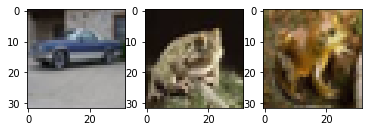

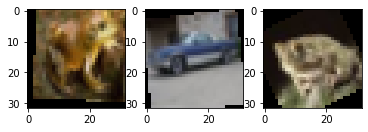

In [57]:
N = 3
f = datagen.flow(x_train[0:N,...], y_train[0:N,...], batch_size=N)
im = next(f)
print(type(f))
print(type(im[0]), type(im[1]))

def show(im):
    images = im[0]
    labels = im[1]
    N, w,h,c = images.shape
    for i in range(N):
        plt.subplot(1,N, i+1)
        plt.imshow(images[i])
    plt.show()
        
show((x_train[0:N,...], y_train[0:N,...]))
        
show(im)

In [17]:
images = im[0]
labels = im[1]

In [19]:
images.shape

(2, 32, 32, 3)